In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pickle
from copy import deepcopy
import random 
import numpy as np
from matplotlib import pyplot as plt


In [ ]:
# Nodes
n = 7
clients = [ i for i in range(n) if i !=0]
nodes = [0]+clients #+[n-1]
arcs = [(i,j) for i in nodes for j in nodes if i!=j]
cost = random.sample(range(20,200),len(arcs))
c = { arcs[i]:  cost[i] for i in range(len(arcs))}

np.random.seed(0)
q = {n:np.random.randint(10,15) for n in clients}
#q[0] = 0
#q[6] = 0
Q = 1000

# coordinates
X = np.random.rand(len(nodes))*100
Y = np.random.rand(len(nodes))*100

In [ ]:
# distance
distance = {(i,j): np.hypot(X[i]-X[j],Y[i]-Y[j]) for i in nodes for j in nodes if i!=j}


In [ ]:
plt.figure(figsize=(12,5))
plt.scatter(X,Y,color =  'blue')

#DC
plt.scatter(X[0],Y[0],color = 'red', marker='D')
plt.annotate('DC',(X[0]-1,Y[0]-5.5))

for i in clients:
    plt.annotate('$q_{%d}=%d$'%(i,q[i]),(X[i]-1,Y[i]-5.5))
    
plt.xlabel('Distance X')
plt.ylabel('Distance Y')
plt.title('Solution Travel Salesman Problem')
plt.show()

In [ ]:
# not connected!
#arcs = [(0,1),(0,2), (0,5), (1,2),(1,3),(1,4),(1,5),(1,6),(2,3),(2,6),(3,4),(4,5),(5,6),(2,1),(3,1),(4,1),(5,1),(3,2),(4,3),(5,4)]
#cost = [11,10,10,5,15,15,5,10,15,10,20,15,10,5,15,15,5,15,20,15]
#c = { arcs[i]:  cost[i] for i in range(len(arcs))}

In [ ]:
# Create Model
m = gp.Model('CVRP')

In [ ]:
# Adding variables
x = m.addVars(arcs,vtype = GRB.BINARY,name='x')         # x = arcs
u = m.addVars(clients,ub = Q,vtype = GRB.CONTINUOUS,name='u')  # u = clients

In [ ]:
# Objective Function
#m.setObjective(gp.quicksum(c[i,j]*x[i,j] for i,j in arcs),GRB.MINIMIZE)
m.setObjective(gp.quicksum(distance[n]*x[n] for n in arcs),GRB.MINIMIZE)

In [ ]:
#Constraints

# first constraint: check that each customer is visited once by a vehicle
m.addConstrs(gp.quicksum(x[i,j] for j in nodes if j!= i) == 1 for i in clients)
# second constraint: check that if a vehicle visits a client, the vehicle leaves the client
m.addConstrs(gp.quicksum(x[i,j] for i in nodes if j!= i) == 1 for j in clients)
# third constraint: avoid subtours (TO TAKE OUT LATER)
m.addConstrs((x[i,j]==1) >> (u[i]+q[j]== u[j]) for i,j in arcs if j!=0 and i!=0)

m.addConstrs(u[i]>=q[i] for i in clients)
m.addConstrs(u[i]<= Q for i in clients)

In [ ]:
m.Params.timeLimit = 60
m.Params.MIPGap = 0.1
m.optimize()

In [ ]:
print('Objective Function: ',str(round(m.ObjVal,2)))
for v in m.getVars():
    if v.x > 0.9:
        print(str(v.VarName)+'='+str(v.x))
        

In [ ]:
routes = list()
for i in clients:
    if x[(0,i)].x > 0.9:
        aux = [0,i]
        while i != 0:
            j = i
            for k in nodes:
                if j!=k and x[(j,k)].x > 0.9:
                    aux.append(k)
                    i=k
        routes.append(aux)
routes

In [ ]:
import colour as cl

plt.figure(figsize=(12,5))
plt.scatter(X,Y,color = 'blue')

#DC
plt.scatter(X[0],Y[0],color='red',marker='D')
plt.annotate('DC',(X[0]-1,Y[0]-5.5))

for i in clients:
    plt.annotate('$q_{%d}=%d$'%(i,q[i]),(X[i]-1,Y[i]-5.5))
    
for r in range(len(routes)):
    for n in range(len(routes[r])-1):
        i = routes[r][n]
        j = routes[r][n+1]
        plt.plot([X[i],X[j]],[Y[i],Y[j]],color = 'blue',alpha = 0.4)
        
plt.xlabel('Distance X')
plt.ylabel('Distance Y')
plt.title('Vehicle Routing Problem')

<class 'list'>
Restricted license - for non-production use only - expires 2023-10-25
Set parameter TimeLimit to value 100
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 482 rows, 341 columns and 1890 nonzeros
Model fingerprint: 0x7fb8602c
Variable types: 131 continuous, 210 integer (210 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [8e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 120 rows and 11 columns
Presolve time: 0.04s
Presolved: 362 rows, 330 columns, 3054 nonzeros
Variable types: 130 continuous, 200 integer (200 binary)

Root relaxation: objective 1.499662e+03, 212 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1499.66250  

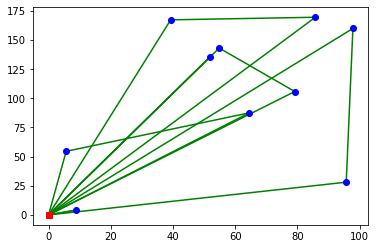

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
from data import Drones, Clients

#Initialization
rnd = np.random
rnd.seed(0)


#Definitions

def solve_VRP(drones,clients_list,time_limit):
    # Basic problem variables
    n = Clients.numeber_of_clients # nodes
    clients = [ i for i in range(1,n+1)]
    nodes = [0]+clients
    N_N_0 = [(i,j) for i in nodes for j in clients if i!=j]
    xc = [0]+[xc.x_coord for xc in clients_list] # customer x locations
    yc = [0]+[yc.y_coord for yc in clients_list] #rnd.rand(n-1)*100 # customer y locations
    print(type(xc))
    T = time_limit # [s] total delivery duration

    # Drone parameters
    M = drones.number_of_drones # Number of drones
    K = 100 # upper bound payload weight
    v = drones.maxspeed # drone speed [m/s]
    Q = drones.maxpayload# max drone payload [kg] 

    # Decision variables
    arcs = [(i,j) for i in nodes for j in nodes if i!=j] # fully connected links
    sigma_var = [(i,j) for i in nodes[1:] for j in nodes[1:]] # going through depot
    y = arcs # payload weight between paths
    t = [i for i in nodes] # time at node i
    a = [i for i in clients] # time between node i and depot

    # Costs
    s = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in arcs} # euclidean distances
    D = {i.number: i.demand for i in clients_list}# demand of client rnd.randint(1,5)


    ### Creating the Model ###
    m = gp.Model('CVRP')

    # Adding decision variables
    x = m.addVars(arcs,vtype = GRB.BINARY,name='x') # x = arcs 
    sigma = m.addVars(sigma_var,vtype = GRB.BINARY,name='sigma') 
    y = m.addVars(y,vtype = GRB.CONTINUOUS,name='y')
    t = m.addVars(t,vtype = GRB.CONTINUOUS,name='t')
    a = m.addVars(a,vtype = GRB.CONTINUOUS,name='a')

    # Objective function
    m.setObjective(gp.quicksum(s[i,j]*x[i,j] for i,j in arcs),GRB.MINIMIZE)

    # Constraints
    m.addConstrs(gp.quicksum(x[i,j] for j in nodes if j!= i) == 1 for i in clients) # (4a)
    m.addConstrs(gp.quicksum(x[i,j] for j in nodes if j!= i)-gp.quicksum(x[j,i] for j in nodes if j!= i)== 0 for i in nodes ) #(4b)
    #Reusability Constrains
    m.addConstrs(gp.quicksum(sigma[i,j] for j in clients) <= x[i,0] for i in clients) # (5a)
    m.addConstrs(gp.quicksum(sigma[j,i] for j in clients) <= x[0,i] for i in clients) # (5b)
    m.addConstr(gp.quicksum(x[0,i] for i in clients) - gp.quicksum(sigma[i,j] for i,j in sigma_var if i!=j) <= M) # (5c)
    #Demand Contrains
    m.addConstrs(gp.quicksum(y[j,i] for j in nodes if j!=i) - gp.quicksum(y[i,j] for j in nodes if j!=i)==D[i] for i in clients) # (6a)
    m.addConstrs(y[i,j] <= K*x[i,j] for i,j in arcs if i!=j) # (6b)
    #Time Constrains
    m.addConstrs(t[i] - t[j] + s[i,j]/v <= K* (1-x[i,j]) for i,j in N_N_0 if i!=j) # (7a)
    m.addConstrs(t[i] - a[i] + s[i,0]/v <= K * (1 - x[i,0]) for i in clients) # (7b)
    m.addConstrs(a[i] - t[j] + s[0,j]/v <= K * (1 - sigma[i,j]) for i,j in sigma_var if i!=j) # (7c)
    m.addConstrs(t[i] <= T  for i in clients) # (7d)  and (7e) CHECK THIS CONSTRAINT
    #
    m.addConstrs(y[i,j] <= Q * x[i,j] for i,j in arcs if i!=j) #(8a)


    m.Params.timeLimit = 100 #[s]
    m.optimize()

    #Plotting
    active_arcs = [a for a in arcs if x[a].x > 0.99]

    for i, j in active_arcs:
        plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)
    plt.plot(xc[0], yc[0], c='r', marker='s')
    plt.scatter(xc[1:], yc[1:], c='b')

    plt.show()


#SAMPLE DATASET

drone1 = Drones("Amazon Drone", 10, 5, 5)#(name, maxspeed, maxpayload, number_of_drones)

client_list = []
for i in range(1,11):
    client = Clients(i, rnd.rand(1)[0]*100,rnd.rand(1)[0]*200, rnd.randint(1,5))
    client_list.append(client)

T = 60 # [s] total delivery duration



if __name__== "__main__":
    solve_VRP(drone1,client_list, T)